In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

In [2]:
np.random.seed(32)

### Data Generation

In [3]:
### Data of g function distribution
### Cos함수와 관련된 데이터를 만드는 함수

# cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)
def Cos(samples, alpha, xmin, xmax):
    """
    Generate datas we will use for the Model
    cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n + Const.)

    INPUT
    samples(int) : number of datas
    coefficients(array)\vec{\aplpha}] : coefficients for the x_i
    dim(int)[\vec{x}] : dimension of x data
    xmax : max value of each x_i
    xmin : min value of each x_i

    OUTPUT
    data sets(\vec{x}, cos(\vec{\alpha} \dot \vec{x}+ Const), Consts)
    """
    points= []
    consts = []
    results = []
    dim = len(alpha)

    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    # Mading sample points
    for i in range(samples):
        
        point = []
        for j in range(dim):
            x  = np.random.uniform(xmin[j], xmax[j])
            array = np.arange(0, 5.1, 0.5)
            const = np.random.choice(array) ## cos(x*a + a0)
            point.append(x)

        result = np.cos(f(alpha, point)+const)
        point.append(const)
        consts.append(const)

        points.append(point)
        results.append(result)

    return np.array(points, requires_grad = False), np.array(results, requires_grad = False), np.array(consts, requires_grad = False)


# ------------------------------------------------------------------ #
alphas = [1, 1/2, 2]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim
Xdata, ydata, const_data = Cos(10, alphas, xmin , xmax)

print(Xdata.shape)
print(Xdata)
print(ydata)
print(Xdata[:,0])

(10, 4)
[[2.69828021 1.32272984 2.36874751 3.5       ]
 [2.56418407 1.4324362  1.91357289 0.5       ]
 [2.59828276 1.08443457 2.79047851 2.        ]
 [1.73254998 2.4019444  0.15686839 4.        ]
 [2.86170292 3.05738416 1.17965343 2.        ]
 [0.51026924 0.50461542 2.28760919 1.        ]
 [1.47511065 0.14156775 1.11955589 0.5       ]
 [2.79738967 1.55204688 1.57310416 1.        ]
 [1.45489713 1.57436179 2.286782   1.5       ]
 [1.11692237 0.91111585 1.4360838  0.5       ]]
[ 0.56593415  0.24394694 -0.27069721  0.57017814 -0.78065939  0.99850924
 -0.41449031  0.13395631 -0.44543528  0.23017635]
[2.69828021 2.56418407 2.59828276 1.73254998 2.86170292 0.51026924
 1.47511065 2.79738967 1.45489713 1.11692237]


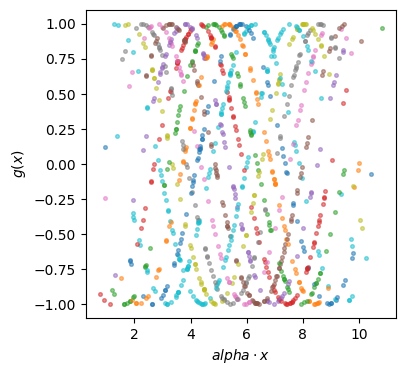

In [4]:
def plot_data(x, alpha, y, const_data, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a
    
    for i in range(len(x)):
        x1 = f(alpha, x[i])
        x2 = y[i]
        color_val = int(const_data[i] * 2 -1)
        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][color_val]
        ax.scatter(x1, x2, alpha=0.5, s= 7, color = color)
        ax.set_xlabel("$alpha \cdot x$")
        ax.set_ylabel("$g(x)$")

# ------------------------------------------------------------------ #

fig, ax = plt.subplots(figsize=(4, 4))
Xdata, ydata , const_data = Cos(1000, alphas, xmin=xmin, xmax = xmax)
plot_data(Xdata[:,:xdim], alphas, ydata, const_data, fig, ax) # for making cos(x*a + a0)

### VQC_Model for function approximation

[0.88639163 0.60627333 0.89413604 0.9460936  0.48998663 0.41057957
 0.79802121 0.09252328 0.46934422 0.45464283 0.02927358 0.65215117
 0.34667787 0.64206332 0.75623014 0.60585088 0.13634996 0.30192434
 0.82039856 0.18495217 0.53981127 0.95570506 0.73964961 0.29688272
 0.81935592 0.48576756 0.44395697 0.25817068 0.6800706  0.00488871
 0.42888359 0.60476285 0.76067511 0.44378031 0.88063882 0.31886259
 0.21183272 0.66725808 0.44980607 0.4998703  0.36943058 0.52472901]
4
------------------------------------------------------------------
0.23541433988762483
------------------------------------------------------------------


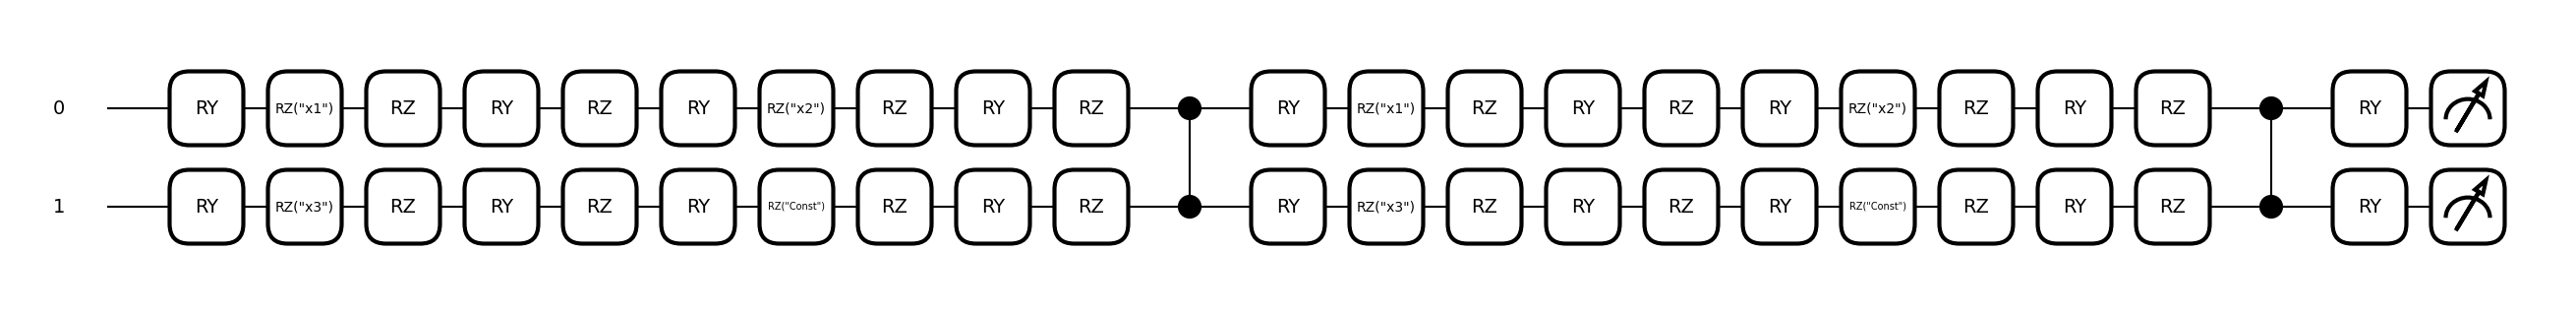

In [6]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    xdim = dim -1
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            if i+1 <= xdim :
                qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i+1}') # Re-uploading data here
            else:
                qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'Const')
            qml.RZ(params[idx+2], wires = qubit)
            qml.RY(params[idx+3], wires = qubit)
            qml.RZ(params[idx+4], wires = qubit)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        idx = -1
        for i in range(num_qubits):
           qml.RY(thetas[idx - i], wires=i)
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #
alphas = [1, 1/2, 2]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim

Xdata, ydata, const_data = Cos(10, alphas, xmin, xmax)
x = Xdata[0]
dim = len(x)
num_layers = 2
num_qubits = math.ceil(len(x) / 2)

thetas = np.random.uniform(size = dim*num_layers*5 + num_qubits,requires_grad = True)


print(thetas)
print(len(x))
print('------------------------------------------------------------------')
print(VQC_Model(thetas, x, num_layers))
print('------------------------------------------------------------------')
fig, ax = qml.draw_mpl(VQC_Model)(thetas, x, num_layers)


### Cost function

In [7]:
def cost_function(thetas, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

### Model Running

In [8]:
def model_running(thetas, x, num_layers):
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

### Utility

In [9]:
def accuracy(ypred, ydata):

    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
       
    return score / len(ydata)

In [10]:
def iterate_minibatches(inputs, targets, batch_size):
    
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------

### Training

In [11]:
### Preparing datas
alphas = [1, 1/2, 2]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim

train_data, train_target, train_const = Cos(500, alphas, xmin, xmax)
test_data, test_target, test_const = Cos(1000, alphas, xmin, xmax)

# for making cos(x*a + a0)
x = train_data[0]
dim = len(x)

# Trainnig option settings
num_layers = 2
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5 + num_qubits, requires_grad=True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(thetas, train_data, num_layers)
score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(thetas, test_data, num_layers)
score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(thetas, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, _, _, _ = opt.step(cost_function, thetas, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, train_data, num_layers)
    score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, train_data, num_layers, train_target)

    pred_test = model_running(thetas, test_data, num_layers)
    score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 0.801374 | Train accuracy: 0.094000 | Test Accuracy: 0.095000
Epoch:  1 | Loss: 0.563779 | Train accuracy: 0.032000 | Test accuracy: 0.035000
Epoch:  2 | Loss: 0.513051 | Train accuracy: 0.042000 | Test accuracy: 0.029000
Epoch:  3 | Loss: 0.488175 | Train accuracy: 0.014000 | Test accuracy: 0.029000
Epoch:  4 | Loss: 0.440638 | Train accuracy: 0.034000 | Test accuracy: 0.042000
Epoch:  5 | Loss: 0.406340 | Train accuracy: 0.030000 | Test accuracy: 0.047000
Epoch:  6 | Loss: 0.376751 | Train accuracy: 0.066000 | Test accuracy: 0.067000
Epoch:  7 | Loss: 0.354077 | Train accuracy: 0.080000 | Test accuracy: 0.072000
Epoch:  8 | Loss: 0.319009 | Train accuracy: 0.072000 | Test accuracy: 0.074000
Epoch:  9 | Loss: 0.247844 | Train accuracy: 0.076000 | Test accuracy: 0.099000
Epoch: 10 | Loss: 0.128313 | Train accuracy: 0.220000 | Test accuracy: 0.242000
Epoch: 11 | Loss: 0.030179 | Train accuracy: 0.530000 | Test accuracy: 0.514000
Epoch: 12 | Loss: 0.009764 | Train accur

Cost: 0.000076 | Train accuracy 0.974000 | Test Accuracy : 0.961000
Learned weights
thetas = [ 0.35990756 -0.24402525  0.22607502  0.32220813  0.52144637  0.66986454
  0.0265549  -0.15649113  0.26882798 -0.17336836  0.78491894  0.46708748
 -0.38929469  0.21993961 -0.31267929  0.59271594 -0.14807321 -0.80737464
  0.04370007 -0.27951558 -1.52315612  1.00506376  0.36876927 -0.10859454
  0.65762715  0.21318487  0.50013869  0.01109361  0.1695454  -0.17122348
 -0.00406431  1.68504101 -0.1193096   0.05679952  0.09314553 -0.06991173
  1.14409323  0.48189026  0.00585462  0.2939012   1.55581708  1.57179455]


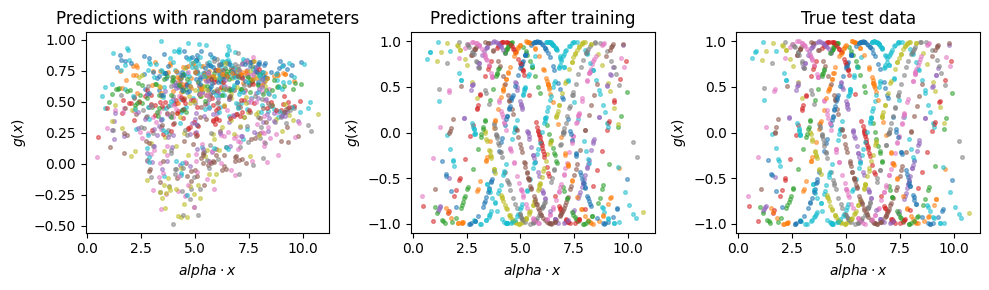

In [12]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
print("thetas = {}".format(thetas))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data[:,:xdim], alphas, initial_predictions, test_const, fig, axes[0])
plot_data(test_data[:,:xdim], alphas, pred_test, test_const, fig, axes[1])
plot_data(test_data[:,:xdim], alphas, test_target, test_const, fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


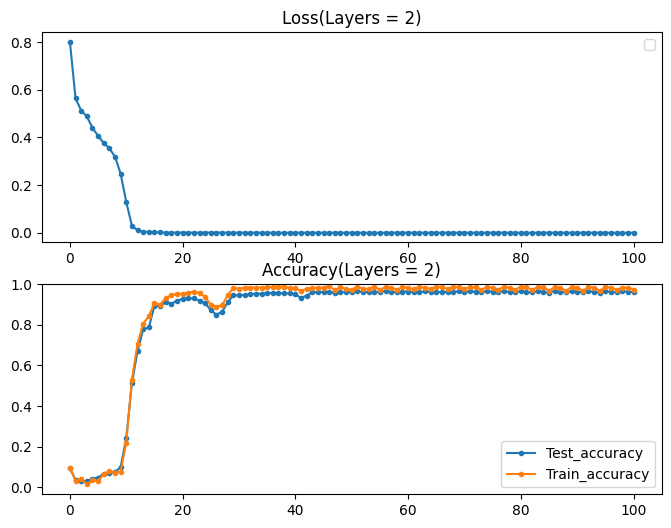

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss(Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

### Results for $g_{est}$

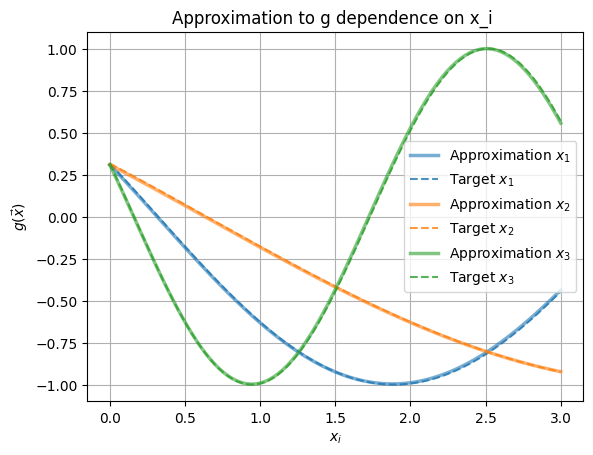

In [22]:
xlin = np.linspace(0, 3,100)
arr = np.zeros(100)
alpha0 = [1.25]*100

alphas = [1, 1/2, 2]
xdim = len(alphas)

xlin_data1 = np.stack((xlin, arr, arr, alpha0), axis=1)
xlin_data2 = np.stack((arr, xlin, arr, alpha0), axis=1)
xlin_data3 = np.stack((arr, arr, xlin, alpha0), axis=1)

xlin_data = np.stack((xlin_data1, xlin_data2, xlin_data3), axis=0)

for i in range(xdim):
        ypred = model_running(thetas, xlin_data[i], num_layers)
        ytrue = np.cos(alphas[i]*xlin+alpha0)

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(xlin, 
                ypred,
                label=f"Approximation $x_{i+1}$",
                linewidth = 2.5,
                alpha = 0.6,
                ls = "-",
                color = color)

        plt.plot(
                xlin,
                ytrue,
                label=f"Target $x_{i+1}$",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color)
        
plt.grid(True)
plt.title(f"Approximation to g dependence on x_i ")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$g({\vec{x}})$")
plt.legend()
plt.show()

### Results for $I(\cdots,x_{i-1},x_{i+1},\cdots)$

#### 변수 $x_2$와 $x_3$에 대한 적분을 수행하고 그 결과를 $ x_1 $값의 함수로 표현하고 싶다면, 우리는 두 변수에 대한 이중적분을 계산

#### 함수 $ f(x_1, x_2, x_3) = \cos(x_1 + 2x_2 + 0.5x_3 + \alpha_0) $에 대해 $ \alpha_0 = 1.25 $로 고정하고, $ x_2 $와 $ x_3 $에 대해 0부터 3까지의 적분을 리만 적분으로 근사

1. **이중적분 설정**:
$ I(x_1) = \int_{0}^{3} \int_{0}^{3} \cos(x_1 + 2x_2 + 0.5x_3 + 1.25) \, dx_2 \, dx_3 $

2. **구간 나누기**:
두 변수 $ x_2 $와 $ x_3 $에 대해 구간 [0, 3]을 $ N $개의 작은 구간으로 나눕니다. 각 변수에 대한 구간의 너비는 $ \Delta x = \frac{3 - 0}{N} $로 동일

3. **함수의 값 계산**:
이중 합을 사용하여 리만 합을 계산하기 위해, 각 구간에 대한 대표값 $ x_{2i} $와 $ x_{3j} $에서 함수의 값을 계산

4. **이중 리만 합 계산**:
각 대표값에서 함수의 값을 곱한 후, 모든 $ x_2 $와 $ x_3 $의 구간에 대해 이를 더하여 이중 리만 합을 계산

$ I_{\text{Riemann}}(x_1) = \sum_{i=1}^{N} \sum_{j=1}^{N} \cos(x_1 + 2x_{2i} + 0.5x_{3j} + 1.25) \Delta x^2 $

5. **적분값 계산**:
리만 합을 계산한 후, $ N $을 충분히 크게 취하여 근사적분값 $ I_{\text{Riemann}}(x_1) $이 실제 이중적분 값에 근사됨

6. **결과 해석**:
$ x_1 $에 대해 $ I_{\text{Riemann}}(x_1) $를 계산하면, 이는 $ x_1 $의 함수로서의 이중적분 결과를 얻을 수 있음

In [16]:
xlin = np.linspace(0,1,100)

In [39]:
# Define the integrand function
def integrand(thetas, x, num_layers):
    return model_running(thetas, x, num_layers)
# Set the value for alpha0
alpha0 = 1.25

# Set the bounds of the integration for x2 and x3
lower_bound = 0
upper_bound = 1

# Choose the number of points for the Riemann sum (more points -> better approximation)
N = 301  # This is an example; in practice, you might need a larger number for a good approximation
delta_x = (upper_bound - lower_bound) / (N-1)
 
# Initialize the sum
I_riemann = 0

# Compute the Riemann sum
integral_results = []
for x1 in xlin:
    I_riemann = 0
    for i in range(N):
        for j in range(N):
            x2 = lower_bound + i * delta_x
            x3 = lower_bound + j * delta_x
            int_data = np.array([[x1,x2,x3,alpha0]], requires_grad=False)
            I_riemann += integrand(thetas, int_data, num_layers) * delta_x**(xdim-1)
    integral_results.append(I_riemann)


In [40]:
# To-do: numerical integration results, maybe we can use integrand with true g(x,a)
#ytrue = -0.943495985118008*np.sin(xlin) - 0.170911422467665*np.cos(xlin)

ytrue = np.sin(xlin+5/2)-np.sin(xlin+1/2)-np.sin(xlin+2)+np.sin(xlin) #On hand

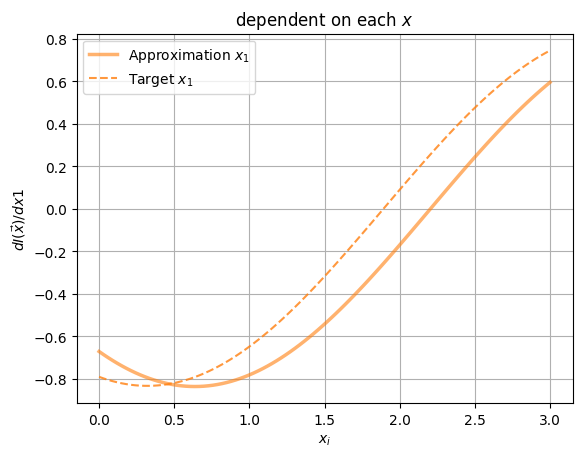

In [41]:
i = 1 # x_1
color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

plt.plot(xlin, 
        integral_results,
        label=f"Approximation $x_{i}$",
        linewidth = 2.5,
        alpha = 0.6,
        ls = "-",
        color = color)

plt.plot(
        xlin,
        ytrue,
        label=f"Target $x_{i}$",
        linewidth=1.5,
        alpha=0.8,
        ls="--",
        color=color)
        
plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$dI({\vec{x}})/ dx1$")
plt.legend()
plt.show()